In [1]:
#meta 9/30/2020 My Own MNIST.  3 or 7 classifier
#Start with manual Gradient Descent
#Multivariate logistic regression, parameters - weights & bias

#Make it work with fast.ai, so I understand how all the pieces connect together, and move on to MNIST digit classifier

In [2]:
#hide
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

In [3]:
#hide
from fastai.vision.all import *
from fastbook import *
#import graphviz
matplotlib.rc('image', cmap='Greys')

# Training a Digit Classifier
Create a model that can recognize 3s and 7s.

## 0. Load Data 
From pickle  
Common layout for ML datasets: separate folders for train and validation (and/or) test sets.


In [4]:
#!pwd

X_train = torch.load( 'myData/04_mnist_sample_X_train.pkl') #class torch.Tensor
y_train = torch.load( 'myData/04_mnist_sample_y_train.pkl') #class torch.Tensor
X_valid = torch.load( 'myData/04_mnist_sample_X_valid.pkl') 
y_valid = torch.load( 'myData/04_mnist_sample_y_valid.pkl')

X_train.shape, y_train.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

Dimensions

In [5]:
#tensor rank
print(len(X_train.shape), len(y_train.shape))
#can also get rank with 'ndim'
#print(X_train.ndim, y_train.ndim)

2 2


> python PIL: `Image` class from the Python Imaging Library (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.

> pandas: background_gradient() color-code the values using a gradient

In [6]:
##loak at one image
#im3_path = threes[1]
#im3 = Image.open(im3_path)
#print("Type: ", type(im3))
#im3


In [7]:
##convert an image PyTorch tensor
##preview data
#tensor(im3)[4:10,4:10]

##shows us clearly how the image is created from the pixel values
#im3_t = tensor(im3)
#df = pd.DataFrame(im3_t[4:15,4:22])
#df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

This is how an image looks like to a computer.


> PyTorch: Tensor Vocab  
*rank* is the number of axes (or dimensions) in a tensor  
*shape* is the size of each axis of a tensor.
    - In this case, we can see that we have 6,131 images, each of size 28×28 pixels  
*length* of a tensor's shape is its rank. 

Using the term *dimension* may lead to confustion. When confused, it's helpful to translate all statements into terms of rank, axis, and length, which are unambiguous terms.

## 2. Train Model with Gradient Descent
`X` is the image, represented as a vector  
`w` is the weights, also a vector  
We need some way to update the weights to make them a little bit better. We can repeat that step a number of times, making the weights better and better, until they are as good as we can make them.

Find the best vector `w` which results in the best function for recognising 3s, which means the result to be high for those images that are actually 3s, and low for those images that are not. 


To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

These seven steps, illustrated in [gradient_descent](###-summarizing-gradient-descent), are the key to the training of all deep learning models. That deep learning turns out to rely entirely on these steps is extremely surprising and counterintuitive. It's amazing that this process can solve such complex problems!

the general approach to each one generally follows some basic principles. Here are a few guidelines:

- Initialize:: We initialize the parameters to random values. This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well.
- Loss:: This is what Samuel referred to when he spoke of *testing the effectiveness of any current weight assignment in terms of actual performance*. We need some function that will return a number that is small if the performance of the model is good (the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention).
- Step:: A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating *gradients*. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.
- Stop:: Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision. This is where that decision is applied. For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.

>PyTorch: special method `requires_grad_`? The magical incantation we use to tell PyTorch that we want to calculate gradients with respect to that variable at that value. It is essentially tagging the variable, so PyTorch will remember to keep track of how to compute gradients of the other, direct calculations on it that you will ask for.  

In deep learning, "gradients" usually means the _value_ of a function's derivative at a particular argument value. 

>PyTorch: The "backward" here refers to *backpropagation*, which is the name given to the process of calculating the derivative of each layer. 

Later, when we calculate the gradients of a deep neural net from scratch. This is called the "backward pass" of the network, as opposed to the "forward pass," which is where the activations are calculated. Life would probably be easier if `backward` was just called `calculate_grad`, but deep learning folks really do like to add jargon everywhere they can!

### 2.1 GD Manually with MNIST tiny subset
A dataset with more dimensions to understand Gradient Descent and see that it finds params pretty well.


In [8]:
#limit X #$actemp
X_train_min = X_train[:3]
y_train_min = y_train[:3]
    
X_train_min.shape, y_train_min.shape

(torch.Size([3, 784]), torch.Size([3, 1]))

#### Global variables

In [9]:
#reproducibility $accheck
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

#Global vars and functions
lr = 1.


#### Define GD functions 

In [10]:
#must tell PyTorch that we want gradients
def init_params(size, var=1.0): return (torch.randn(size)*var).requires_grad_()

# hypothesis X*theta.T
def linear(input_X): return input_X@weights + bias

# cost function J with embedded loss function
def mnist_loss(prediction_yhat, output_y):
    #scale predicitons
    prediction_yhat = prediction_yhat.sigmoid()
    return torch.where(output_y==1, 1-prediction_yhat, prediction_yhat).mean()


#### Manually step thru
#### Step 1: Initialize the parameters

In [11]:
## Step 1: Initialize the parameters
weights = init_params((28*28,1))
bias = init_params(1)


In [12]:
original_weights = weights.clone()
original_bias = bias.clone()
print(original_weights[:10], original_bias, sep='\n')

tensor([[ 1.9269],
        [ 1.4873],
        [ 0.9007],
        [-2.1055],
        [ 0.6784],
        [-1.2345],
        [-0.0431],
        [-1.6047],
        [-0.7521],
        [ 1.6487]], grad_fn=<SliceBackward>)
tensor([0.3472], grad_fn=<CloneBackward>)


#### Step 2: Calculate the predictions
`y_hat = w*X+b`  
really `sigmoid(y_hat = w*X+b)`  
sigmoid implemented in the `mnist_loss` function

In [13]:
## Step 2: Calculate the predictions
y_hat = linear(X_train_min)
y_hat.shape

torch.Size([3, 1])

#### Step 3: Calculate the loss

In [14]:
## Step 3: Calculate the loss
loss = mnist_loss(y_hat, y_train_min)
loss

tensor(0.9993, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients

In [15]:
## Step 4: Calculate the gradients
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-9.4232e-05), tensor([-0.0007]))

#### Step 5: Step the weights. 

In [16]:
## Step 5: adjust step
weights.data -= lr * weights.grad.data
weights.grad = None
bias.data -= lr * bias.grad.data
bias.grad = None


#### Step 6: Repeat the process 

In [17]:
def apply_step(weights, bias, prn=True):
    ## Step 2: Calculate the prediction
    predictions_yhat = linear(X_train_min)
    ## Step 3: Calculate the loss
    loss = mnist_loss(predictions_yhat, y_train_min)
    ## Step 4: Calculate the gradients
    loss.backward()
    ## Step 5: adjust step    
    weights.data -= lr * weights.grad.data
    weights.grad = None
    bias.data -= lr * bias.grad.data
    bias.grad = None
    
    if prn: 
        print("loss: ", loss.item())
        
    return predictions_yhat

In [18]:
n_loop = 10
for i in range(n_loop): 
    p = apply_step(weights, bias) 
    if not p == None: print("predictions: \n", p)

loss:  0.9992944598197937
predictions: 
 tensor([[ -6.1677],
        [-10.5913],
        [-20.8409]], grad_fn=<AddBackward0>)
loss:  0.9992437362670898
predictions: 
 tensor([[ -6.0980],
        [-10.5407],
        [-20.7924]], grad_fn=<AddBackward0>)
loss:  0.9991855025291443
predictions: 
 tensor([[ -6.0233],
        [-10.4864],
        [-20.7403]], grad_fn=<AddBackward0>)
loss:  0.9991176128387451
predictions: 
 tensor([[ -5.9429],
        [-10.4280],
        [-20.6843]], grad_fn=<AddBackward0>)
loss:  0.9990377426147461
predictions: 
 tensor([[ -5.8558],
        [-10.3647],
        [-20.6235]], grad_fn=<AddBackward0>)
loss:  0.9989424347877502
predictions: 
 tensor([[ -5.7608],
        [-10.2957],
        [-20.5574]], grad_fn=<AddBackward0>)
loss:  0.9988269209861755
predictions: 
 tensor([[ -5.6564],
        [-10.2199],
        [-20.4846]], grad_fn=<AddBackward0>)
loss:  0.9986839294433594
predictions: 
 tensor([[ -5.5406],
        [-10.1359],
        [-20.4040]], grad_fn=<AddBack

In [19]:
print(weights[:10],bias, sep='\n')

tensor([[ 1.9269],
        [ 1.4873],
        [ 0.9007],
        [-2.1055],
        [ 0.6784],
        [-1.2345],
        [-0.0431],
        [-1.6047],
        [-0.7521],
        [ 1.6487]], grad_fn=<SliceBackward>)
tensor([0.3587], requires_grad=True)


#### Step 7: stop
THe model is on the way to learn the best parameters and returns them in the `weights` vector + `bias`. 

### Summarizing Gradient Descent

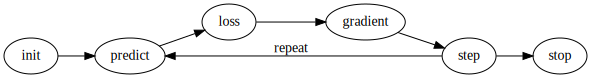

In [20]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

### 2.2 Putting It All Together: GD More Automated with MNIST

#### Define GD functions 

In [21]:
#original code, with original var names
def linear1(xb): return xb@weights + bias

def mnist_loss(predictions, targets):
    #scale predicitons
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

## Step 2-4: Calculate the gradients
def calc_grad(xb, yb, model):
    # Step 2: Calculate the predictions
    preds = model(xb)
    # Step 3: Calculate the loss
    loss = mnist_loss(preds, yb)
    # Step 4: Calculate the gradients
    loss.backward()


#### Define functions to train model and check performance metric - in one run, not in batches

In [22]:
#train model
def train_run(model, lr, params):
    for X,y in zip(X_train, y_train):
        calc_grad(X, y, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

#model accuracy
def run_accuracy(X, y):
    preds = X.sigmoid()
    correct = (preds>0.5) == y
    return correct.float().mean()

#validate model
def validate_run(model):
    accs = [run_accuracy(model(X), y) for X,y in zip(X_valid, y_valid)]
    return round(torch.stack(accs).mean().item(), 4)


#### More automated step thru
#### Step 1: Initialize the parameters

In [23]:
## Step 1: Initialize the parameters
weights = init_params((28*28,1))
bias = init_params(1)

print(weights[:10], bias, sep='\n')

tensor([[ 0.1268],
        [-2.4521],
        [ 0.4160],
        [ 1.9025],
        [-1.3525],
        [-0.1303],
        [ 1.7551],
        [ 0.0675],
        [ 0.7402],
        [ 1.4162]], grad_fn=<SliceBackward>)
tensor([-0.2762], requires_grad=True)


In [24]:
#first GD run
params = weights,bias
train_run(linear1, lr, params)
validate_run(linear1)

0.5049

#### Execute a run: steps 2 thru 7

In [25]:
# 20 more runs
#reset lr, lr=1. was diverging too fast for the entire dataset
lr = 0.25
params = weights,bias

for i in range(20):
    train_run(linear1, lr, params)
    print(validate_run(linear1), end=' ')

0.6472 0.7699 0.8189 0.8538 0.8739 0.894 0.9082 0.9171 0.9249 0.9274 0.9308 0.9333 0.9328 0.9357 0.9377 0.9411 0.9426 0.9446 0.9465 0.9465 

In [26]:
print(weights[:10],bias, sep='\n')
weights.grad.mean(),bias.grad

tensor([[ 0.1268],
        [-2.4521],
        [ 0.4160],
        [ 1.9025],
        [-1.3525],
        [-0.1303],
        [ 1.7551],
        [ 0.0675],
        [ 0.7402],
        [ 1.4162]], grad_fn=<SliceBackward>)
tensor([-2.6875], requires_grad=True)


(tensor(0.), tensor([0.]))

Done

### 2.3 Putting It All Together: Stochastic GD with MNIST
run batches of data

#### 2.3.0 Load data
from pkl

In [27]:
#!pwd

dset = torch.load( 'myData/04_mnist_sample_dset.pkl') #class list of tuples of torch.Tensor (X, y)
valid_dset = torch.load( 'myData/04_mnist_sample_dset_valid.pkl') #class list of tuples of torch.Tensor (X_valid, y_valid)

dset.__class__, valid_dset.__class__

(list, list)

In [28]:
print(dset[0].__class__)
print(dset[0][0].__class__, dset[0][1].__class__)
print(dset[0][0].shape, dset[0][1].shape)

<class 'tuple'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([784]) torch.Size([1])


In [29]:
#Make batches
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [30]:
valid_dl = DataLoader(valid_dset, batch_size=256)

#### Define SGD functions to train model and check performance metric - in batches
Everything just like above, but now split the dataset into batches and have a for loop for each batch

In [31]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

#### SGD step thru
#### Step 1: Initialize the parameters

In [32]:
## Step 1: Initialize the parameters
weights = init_params((28*28,1))
bias = init_params(1)

print(weights[:10], bias, sep='\n')

tensor([[ 1.2367],
        [-0.8144],
        [-0.7985],
        [ 0.5182],
        [-1.1608],
        [-1.0227],
        [-0.5064],
        [ 0.7802],
        [ 0.6285],
        [-0.7066]], grad_fn=<SliceBackward>)
tensor([-0.6796], requires_grad=True)


In [33]:
##first SGD run
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6546

In [34]:
#run 20 more
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8157 0.8914 0.929 0.9412 0.9485 0.9529 0.9559 0.9573 0.9588 0.9598 0.9612 0.9642 0.9647 0.9661 0.9652 0.9661 0.9691 0.9686 0.9701 0.9716 

### 2.4 Creating an Optimizer 
with PyTorch module `nn.Linear`

In [36]:
linear_model = nn.Linear(28*28,1)

In [37]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [38]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [39]:
opt = BasicOptim(linear_model.parameters(), lr)

In [40]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [41]:
validate_epoch(linear_model)

0.4213

In [42]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [43]:
train_model(linear_model, 20)

0.4932 0.8667 0.8198 0.9102 0.9326 0.9468 0.9555 0.9614 0.9653 0.9678 0.9697 0.9717 0.9731 0.9751 0.9761 0.9765 0.9775 0.9775 0.9785 0.9785 

In [44]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8457 0.833 0.9111 0.9326 0.9463 0.9546 0.9624 0.9653 0.9673 0.9687 0.9712 0.9731 0.9746 0.9761 0.977 0.9775 0.978 0.9785 0.979 

In [45]:
dls = DataLoaders(dl, valid_dl)

In [46]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [47]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636950,0.503386,0.495584,00:00
1,0.480388,0.203609,0.827282,00:00
2,0.177803,0.173354,0.844455,00:00
3,0.078724,0.104282,0.912659,00:00
4,0.042229,0.076654,0.932777,00:00
5,0.027967,0.061644,0.948479,00:00
6,0.022089,0.052264,0.955348,00:00
7,0.019463,0.046005,0.962218,00:00
8,0.018124,0.041601,0.966143,00:00
9,0.017316,0.038352,0.967125,00:00


## Adding a Nonlinearity

In [ ]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [ ]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [ ]:
plot_function??

In [ ]:
plot_function(F.relu)

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
learn.fit(40, 0.1)

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [ ]:
learn.recorder.values[-1][2]

### Going Deeper

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

## Jargon Recap

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.

In [ ]:
#$xtra myTry ok to delete

## function MSE
##def mse(preds, targets): return ((preds-targets)**2).mean()